In [6]:
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf 

import utils

np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [9]:
data = np.loadtxt('./data/data_w3_ex1.csv', delimiter=',')

x = data[:,0]
y = data[:,1]

x = np.expand_dims(x, axis = 1) # convert dimenstion from 1 d to 2d
y = np.expand_dims(y, axis = 1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (50, 1)
the shape of the targets y is: (50, 1)


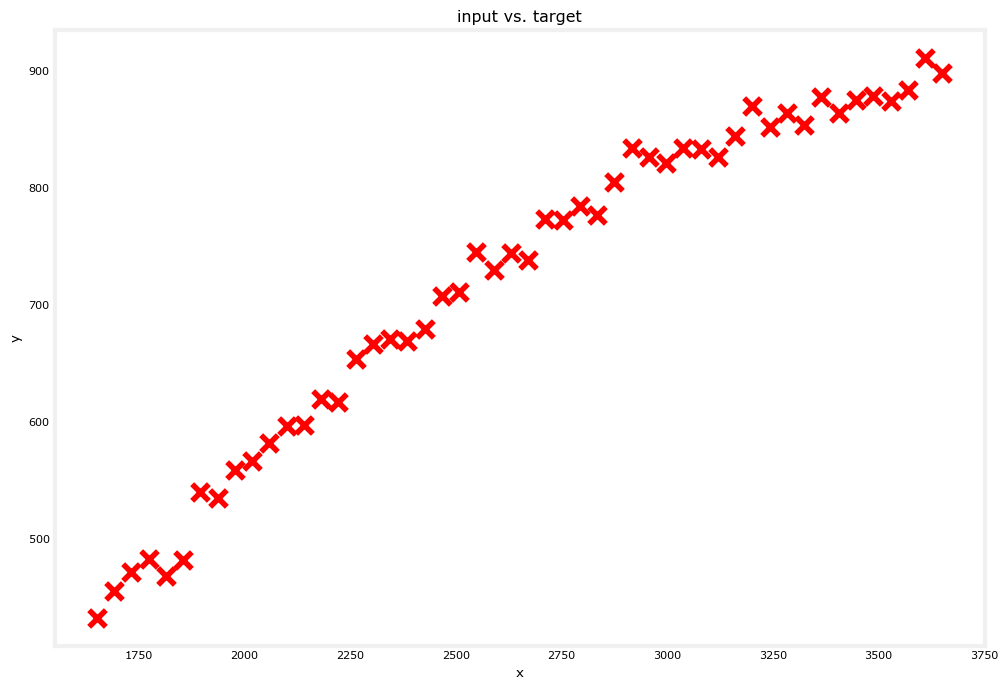

In [10]:
utils.plot_dataset(x=x, y=y, title="input vs. target")

split the dataset 

In [11]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


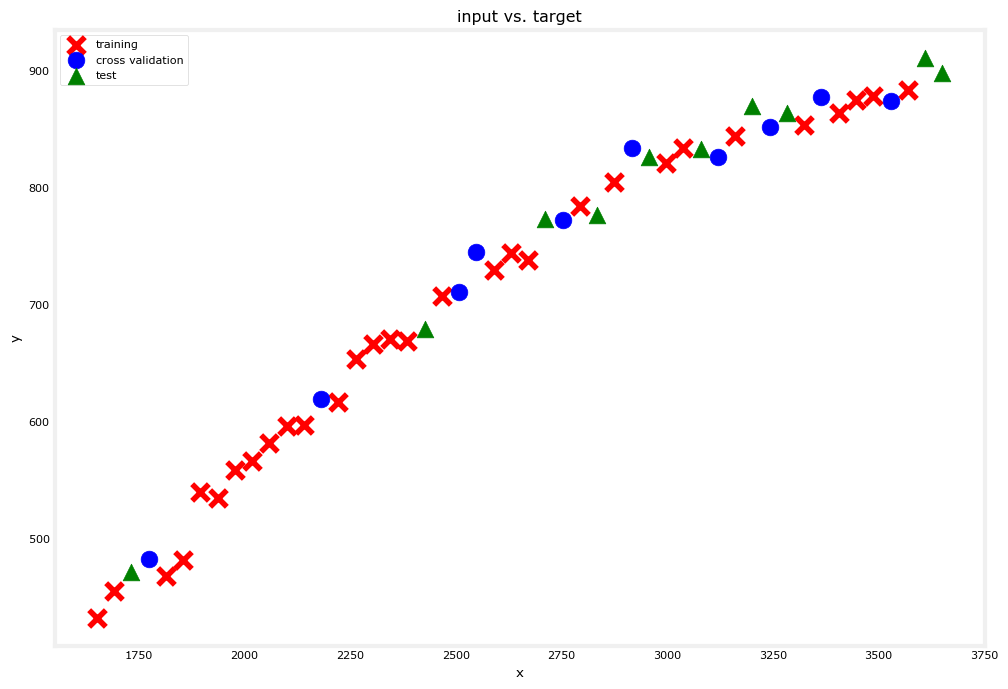

In [12]:
utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title="input vs. target")

### fit the linear model

#### feature scalling

Computed mean of the training set: 2504.06
Computed standard deviation of the training set: 574.85


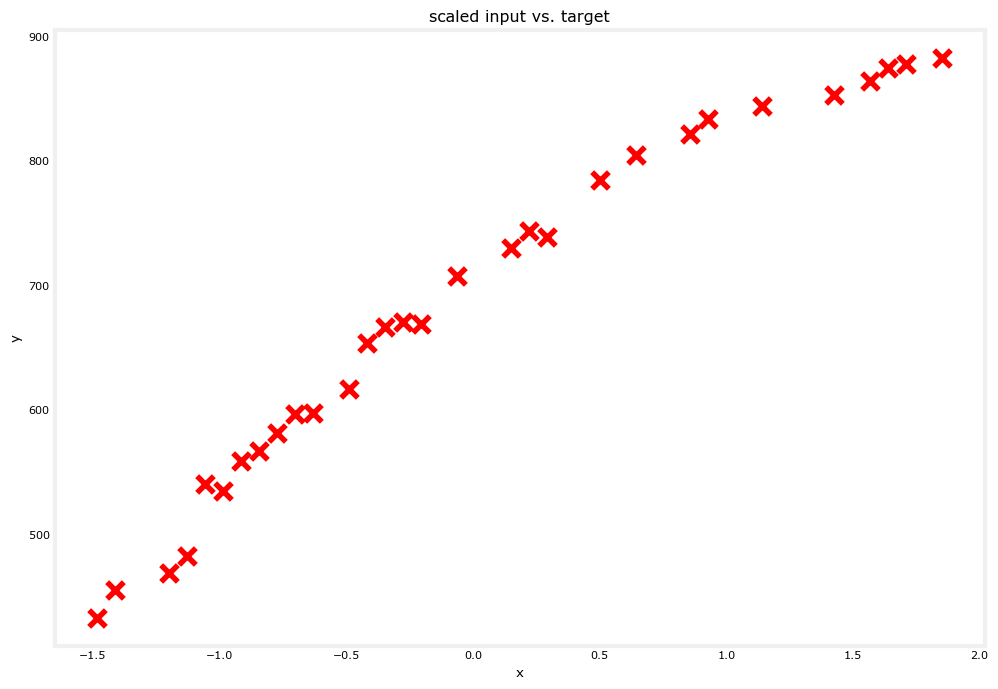

In [13]:
# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

# Plot the results
utils.plot_dataset(x=X_train_scaled, y=y_train, title="scaled input vs. target")

`train the model`

In [15]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled,y_train)

LinearRegression()

#evalute the model


$$J_{train}(\vec{w}, b) = \frac{1}{2m_{train}}\left[\sum_{i=1}^{m_{train}}(f_{\vec{w},b}(\vec{x}_{train}^{(i)}) - y_{train}^{(i)})^2\right]$$

Scikit-learn also has a built-in [`mean_squared_error()`]

In [20]:
yhat = linear_model.predict(X_train_scaled)

print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

#calculating mean squared error
# for loop implemention
total_squared_error = 0

for i in range(len(yhat)):
    squared_error_i  = (yhat[i] - y_train[i])**2
    total_squared_error += squared_error_i

mse = total_squared_error/(2*len(yhat))

print(f"training MSE (for-loop implementation): {mse.squeeze()}")

training MSE (using sklearn function): 406.19374192533155
training MSE (for-loop implementation): 406.19374192533155


You can then compute the MSE for the cross validation set with basically the same equation:

$$J_{cv}(\vec{w}, b) = \frac{1}{2m_{cv}}\left[\sum_{i=1}^{m_{cv}}(f_{\vec{w},b}(\vec{x}_{cv}^{(i)}) - y_{cv}^{(i)})^2\right]$$

As with the training set, you will also want to scale the cross validation set. An *important* thing to note when using the z-score is you have to use the mean and standard deviation of the **training set** when scaling the cross validation set. This is to ensure that your input features are transformed as expected by the model. One way to gain intuition is with this scenario:

* Say that your training set has an input feature equal to `500` which is scaled down to `0.5` using the z-score.
* After training, your model is able to accurately map this scaled input `x=0.5` to the target output `y=300`. 
* Now let's say that you deployed this model and one of your users fed it a sample equal to `500`. 
* If you get this input sample's z-score using any other values of the mean and standard deviation, then it might not be scaled to `0.5` and your model will most likely make a wrong prediction (i.e. not equal to `y=300`). 

You will scale the cross validation set below by using the same `StandardScaler` you used earlier but only calling its [`transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform) method instead of [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform).

In [21]:
# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():.2f}")

# Feed the scaled cross validation set
yhat = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Mean used to scale the CV set: 2504.06
Standard deviation used to scale the CV set: 574.85
Cross validation MSE: 551.7789026952216


## Adding Polynomial Features

In [22]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

# Preview the first 5 elements of the new training set. Left column is `x` and right column is `x^2`
# Note: The `e+<number>` in the output denotes how many places the decimal point should 
# be moved. For example, `3.24e+03` is equal to `3240`
print(X_train_mapped[:5])

[[3.32e+03 1.11e+07]
 [2.34e+03 5.50e+06]
 [3.49e+03 1.22e+07]
 [2.63e+03 6.92e+06]
 [2.59e+03 6.71e+06]]


In [23]:
# Instantiate the class
scaler_poly = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

# Preview the first 5 elements of the scaled training set.
print(X_train_mapped_scaled[:5])

[[ 1.43  1.47]
 [-0.28 -0.36]
 [ 1.71  1.84]
 [ 0.22  0.11]
 [ 0.15  0.04]]


In [24]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(X_train_mapped_scaled, y_train )

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Training MSE: 49.111609334025154
Cross validation MSE: 87.6984121111191


You'll notice that the MSEs are significantly better for both the training and cross validation set when you added the 2nd order polynomial. You may want to introduce more polynomial terms and see which one gives the best performance. As shown in class, you can have 10 different models like this:


You can create a loop that contains all the steps in the previous code cells. Here is one implementation that adds polynomial features up to degree=10. We'll plot it at the end to make it easier to compare the results for each model.

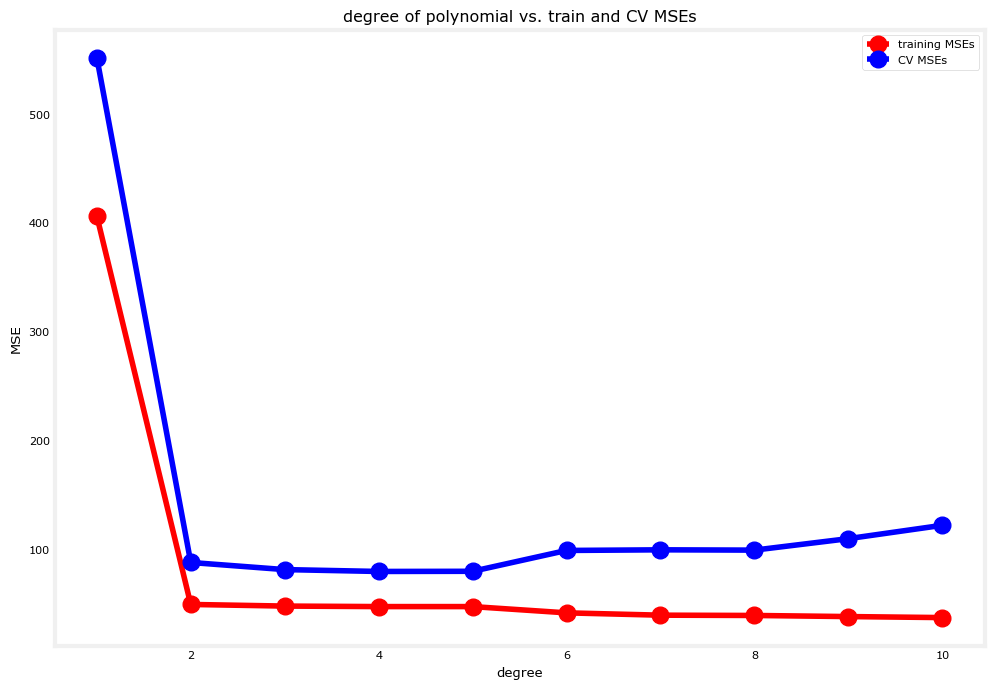

In [25]:
# Initialize lists containing the lists, models, and scalers
train_mses = []
cv_mses = []
models = []
scalers = []

# Loop over 10 times. Each adding one more degree of polynomial higher than the last.
for degree in range(1,11):
    
    # Add polynomial features to the training set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_mapped = poly.fit_transform(x_train)
    
    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)
    
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train )
    models.append(model)
    
    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)
    
    # Add polynomial features and scale the cross validation set
    poly = PolynomialFeatures(degree, include_bias=False)
    X_cv_mapped = poly.fit_transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)
    
    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)
    
# Plot the results
degrees=range(1,11)
utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title="degree of polynomial vs. train and CV MSEs")

### Choosing the best model

When selecting a model, you want to choose one that performs well both on the training and cross validation set. It implies that it is able to learn the patterns from your training set without overfitting. If you used the defaults in this lab, you will notice a sharp drop in cross validation error from the models with degree=1 to degree=2. This is followed by a relatively flat line up to degree=5. After that, however, the cross validation error is generally getting worse as you add more polynomial features. Given these, you can decide to use the model with the lowest `cv_mse` as the one best suited for your application.

In [26]:
# mese mai jo sabse chota hoga usse utha lo it will the best
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree={degree}")

Lowest CV MSE is found in the model with degree=4


In [27]:
# Add polynomial features to the test set
poly = PolynomialFeatures(degree, include_bias=False)
X_test_mapped = poly.fit_transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 47.15
Cross Validation MSE: 79.43
Test MSE: 104.63


## Neural Networks

The same model selection process can also be used when choosing between different neural network architectures. In this section, you will create the models shown below and apply it to the same regression task above.

### Prepare the Data

You will use the same training, cross validation, and test sets you generated in the previous section. From earlier lectures in this course, you may have known that neural networks can learn non-linear relationships so you can opt to skip adding polynomial features. The code is still included below in case you want to try later and see what effect it will have on your results. The default `degree` is set to `1` to indicate that it will just use `x_train`, `x_cv`, and `x_test` as is (i.e. without any additional polynomial features).

In [28]:
# Add polynomial features
degree = 1
poly = PolynomialFeatures(degree, include_bias=False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

In [29]:
# Scale the features using the z-score
scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

### Build and train the models

You will then create the neural network architectures shown earlier. The code is provided in the `build_models()` function in the `utils.py` file in case you want to inspect or modify it. You will use that in the loop below then proceed to train the models. For each model, you will also record the training and cross validation errors.

In [30]:
# Initialize lists that will contain the errors for each model
nn_train_mses = []
nn_cv_mses = []

# Build the models
nn_models = utils.build_models()

# Loop over the the models
for model in nn_models:
    
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    )

    print(f"Training {model.name}...")
    
    # Train the model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs=300,
        verbose=0
    )
    
    print("Done!\n")

    
    # Record the training MSEs
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)
    
    # Record the cross validation MSEs 
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

    
# print results
print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}"
        )

Training model_1...
Done!

1/1 [==============================] - 0s 17ms/step
Training model_2...
Done!

1/1 [==============================] - 0s 17ms/step
Training model_3...
Done!

1/1 [==============================] - 0s 17ms/step
RESULTS:
Model 1: Training MSE: 181.58, CV MSE: 264.48
Model 2: Training MSE: 73.40, CV MSE: 112.41
Model 3: Training MSE: 47.77, CV MSE: 68.94


In [31]:
# Select the model with the lowest CV MSE
model_num = 3

# Compute the test MSE
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 [==============================] - 0s 21ms/step
Selected Model: 3
Training MSE: 47.77
Cross Validation MSE: 68.94
Test MSE: 95.40


## Classification

In this last part of the lab, you will practice model evaluation and selection on a classification task. The process will be similar, with the main difference being the computation of the errors. You will see that in the following sections.

In [32]:
# Load the dataset from a text file
data = np.loadtxt('./data/data_w3_ex2.csv', delimiter=',')

# Split the inputs and outputs into separate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert y into 2-D because the commands later will require it (x is already 2-D)
y_bc = np.expand_dims(y_bc, axis=1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


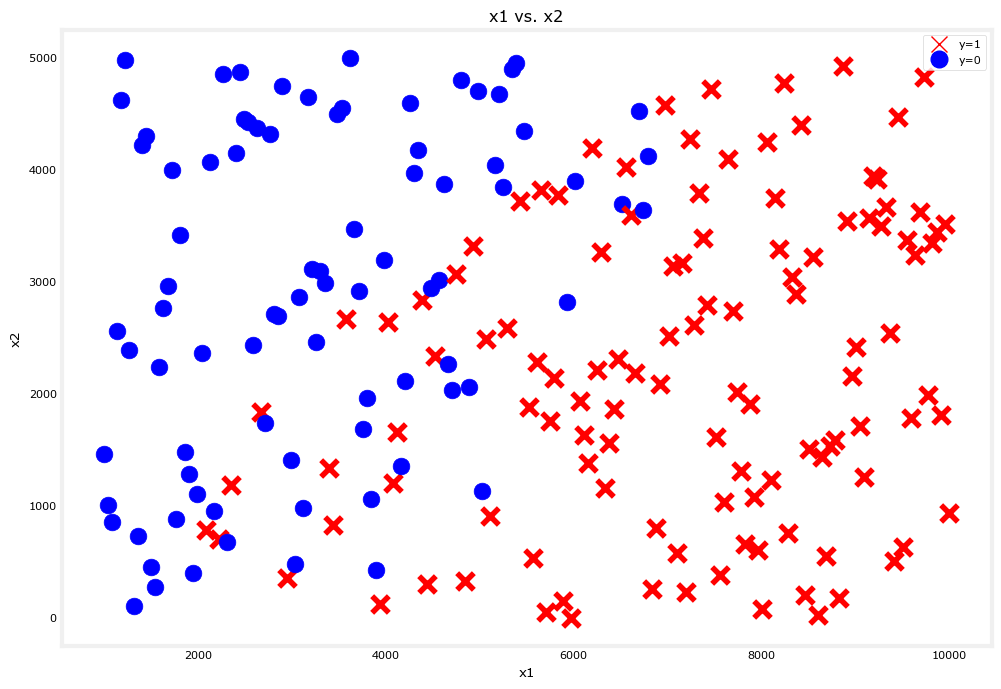

In [33]:
utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

In [34]:
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


In [35]:
# Scale the features

# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

In [36]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Else 0.
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels
ground_truth = np.array([1, 1, 1, 1, 1])

# Initialize counter for misclassified data
misclassified = 0

# Get number of predictions
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):
    
    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:
        
        # Add one to the counter if the prediction is wrong
        misclassified += 1

# Compute the fraction of the data that the model misclassified
fraction_error = misclassified/num_predictions

print(f"probabilities: {probabilities}")
print(f"predictions with threshold=0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold=0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


### Build and train the model

You will use the same neural network architectures in the previous section so you can call the `build_models()` function again to create new instances of these models. 

You will follow the recommended approach mentioned last week where you use a `linear` activation for the output layer (instead of `sigmoid`) then set `from_logits=True` when declaring the loss function of the model. You will use the [binary crossentropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) because this is a binary classification problem.

After training, you will use a [sigmoid function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid) to convert the model outputs into probabilities. From there, you can set a threshold and get the fraction of misclassified examples from the training and cross validation sets.

You can see all these in the code cell below.

In [37]:
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []

# Build the models
models_bc = utils.build_models()

# Loop over each model
for model in models_bc:
    
    # Setup the loss and optimizer
    model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train_scaled, y_bc_train,
        epochs=200,
        verbose=0
    )
    
    print("Done!\n")
    
    # Set the threshold for classification
    threshold = 0.5
    
    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

2/2 [==============================] - 0s 2ms/step
Training model_2...
Done!

2/2 [==============================] - 0s 2ms/step
Training model_3...
Done!

2/2 [==============================] - 0s 1ms/step
Model 1: Training Set Classification Error: 0.07500, CV Set Classification Error: 0.15000
Model 2: Training Set Classification Error: 0.06667, CV Set Classification Error: 0.12500
Model 3: Training Set Classification Error: 0.07500, CV Set Classification Error: 0.17500


In [38]:
# Select the model with the lowest error
model_num = 3

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {model_num}")
print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

2/2 [==============================] - 0s 2ms/step
Selected Model: 3
Training Set Classification Error: 0.0750
CV Set Classification Error: 0.1750
Test Set Classification Error: 0.1750
